In [36]:
# Import modules.

from pathlib import Path
from string import ascii_uppercase

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, rcParams

from seismicrna.cluster.compare import assign_clusterings
from seismicrna.cluster.report import ClusterReport, NumUniqReadKeptF, NumClustsF
from seismicrna.core.header import parse_header
from seismicrna.core.mu import calc_pearson
from seismicrna.mask.report import MaskReport, NumReadsKeptF
from seismicrna.table.base import MUTAT_REL
from seismicrna.table.load import ClustFreqTableLoader, load_pos_table

In [61]:
# Configure.

MAX_CLUSTERS_REAL = 4
MAX_CLUSTERS_OBS = 5
PROP_NAMES = ["Balanced", "Unbalanced", "Very Unbalanced"]
LIBRARIES = [(280, "ampl2"),
             (280, "frag2")]
NUM_READS = [2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]
NUM_TRIALS = 12
ASPECT = 0.8
MM_TO_INCH = 5 / 127
MM_TO_POINT = 360 / 127
rcParams['font.family'] = "Helvetica Neue"
rcParams['font.size'] = 6.0

In [3]:
# Define basic data collection and processing functions.

def list_orders():
    return list(range(1, MAX_CLUSTERS_REAL + 1))


def list_proportions(order: int):
    return list(zip(range(1, (len(PROP_NAMES) if order > 1 else 1) + 1),
                    PROP_NAMES))


def format_sample_name(order: int,
                       props: int,
                       library: str,
                       n_reads: int):
    return f"c{order}-{props}-{library}-n{n_reads}"


def format_ref_name(length: int, trial: int):
    return f"ref-{length}" + (f"-{trial}" if trial else "")


def find_muts_param_file(length: int, trial: int, order: int):
    """ Find the path to a mutation rate parameter file. """
    filename = f"c{order}.muts.csv"
    ref = format_ref_name(length, trial)
    return Path("sim", "params", ref, "full", filename)


def find_clusts_param_file(order: int, proportions: int):
    """ Find the path to a cluster proportions parameter file. """
    filename = f"c{order}-{proportions}.csv"
    return Path("clusts", filename)


def find_table_dir(length: int,
                   trial: int,
                   order: int,
                   props: int,
                   library: str,
                   n_reads: int):
    """ Find the directory of a table file. """
    sample = format_sample_name(order, props, library, n_reads)
    ref = format_ref_name(length, trial)
    return Path("sim", "samples", sample, "table", ref, "full")


def find_pos_table_file(length: int,
                        trial: int,
                        order: int,
                        props: int,
                        library: str,
                        n_reads: int):
    """ Find the path to a table file of positions. """
    return Path(find_table_dir(length, trial, order, props, library, n_reads),
                "clust-per-pos.csv")


def find_clust_table_file(length: int,
                          trial: int,
                          order: int,
                          props: int,
                          library: str,
                          n_reads: int):
    """ Find the path to a table file of cluster proportions. """
    return Path(find_table_dir(length, trial, order, props, library, n_reads),
                "clust-freq.csv")


def find_report_file(step: str,
                     length: int,
                     trial: int,
                     order: int,
                     props: int,
                     library: str,
                     n_reads: int):
    """ Find the path to a report file. """
    sample = format_sample_name(order, props, library, n_reads)
    ref = format_ref_name(length, trial)
    return Path("sim", "samples", sample, step, ref, "full", f"{step}-report.json")


def find_mask_report_file(length: int,
                          trial: int,
                          order: int,
                          props: int,
                          library: str,
                          n_reads: int):
    """ Find the path to a mask report file. """
    return find_report_file("mask", length, trial, order, props, library, n_reads)


def find_clust_report_file(length: int,
                           trial: int,
                           order: int,
                           props: int,
                           library: str,
                           n_reads: int):
    """ Find the path to a cluster report file. """
    return find_report_file("cluster", length, trial, order, props, library, n_reads)


def get_num_reads(mask_report: Path):
    report = MaskReport.load(mask_report)
    return int(report.get_field(NumReadsKeptF))


def get_num_clusters(cluster_report: Path):
    report = ClusterReport.load(cluster_report)
    return int(report.get_field(NumClustsF))


def get_num_uniq_reads(cluster_report: Path):
    report = ClusterReport.load(cluster_report)
    return int(report.get_field(NumUniqReadKeptF))


def load_expected_mus(csv_file: str | Path):
    """ Load expected mutation rates from a CSV file. """
    data = pd.read_csv(csv_file,
                       index_col=list(range(2)),
                       header=list(range(3)))
    # Cast the columns from str to int.
    clusters = parse_header(data.columns)
    data.columns = clusters.index
    raw_mut_rate = (data.loc[:, "16"]
                    + data.loc[:, "32"]
                    + data.loc[:, "64"]
                    + data.loc[:, "128"])
    mus = raw_mut_rate / (raw_mut_rate + data.loc[:, "1"])
    return mus.loc[:, clusters.max_order]


def load_observed_mus(table_file: str | Path):
    """ Load observed mutation rates from a table file. """
    table = load_pos_table(Path(table_file))
    return table.fetch_ratio(rel=MUTAT_REL)[MUTAT_REL, table.header.max_order]


def order_observed_mus(observed_mus: pd.DataFrame, assignments: np.ndarray):
    """ Assign the observed mutation rates in the proper order. """
    return pd.DataFrame(observed_mus.values[:, assignments],
                        index=observed_mus.index,
                        columns=observed_mus.columns)


def order_observed_pis(observed_pis: pd.DataFrame, assignments: np.ndarray):
    """ Assign the observed proportions in the proper order. """
    return pd.Series(observed_pis.values[assignments],
                     index=observed_pis.index)


def load_expected_pis(csv_file: str | Path):
    """ Load expected cluster proportions from a CSV file. """
    data = pd.read_csv(csv_file, index_col=list(range(2)))
    clusters = parse_header(data.index)
    return data.loc[clusters.max_order, "Proportion"]


def load_observed_pis(csv_file: str | Path):
    """ Load observed cluster proportions from a CSV file. """
    table = ClustFreqTableLoader(csv_file)
    data = table.data.loc[table.header.max_order]
    return data / data.sum()


def calc_rms(x):
    """ Root-mean-square. """
    return np.sqrt(np.nanmean(np.square(np.asarray(x))))


def calc_pearson_corr(x, y):
    """ Pearson correlation. """
    return calc_pearson(np.asarray(x).reshape(-1),
                        np.asarray(y).reshape(-1))

In [4]:
# Load all data.

def calc_data(only_trial: int | None):
    """ DataFrame of the difference between every observed and expected
    mutation rates in every simulated dataset. """
    print("Calc Data")
    n_reads_data = list()
    proportions_data = dict()
    for order in list_orders():
        print("Clusters:", order)
        proportions_data[order] = list()
        for props, pname in list_proportions(order):
            print("Proportions:", pname)
            for length, library in LIBRARIES:
                print("Library:", length, library)
                for trial in range(NUM_TRIALS):
                    if only_trial is not None and trial != only_trial:
                        continue
                    print("Trial:", trial)
                    for n_reads_bin, n_reads in enumerate(NUM_READS, start=1):
                        print("Reads:", n_reads)
                        mask_report_file = find_mask_report_file(length,
                                                                 trial,
                                                                 order,
                                                                 props,
                                                                 library,
                                                                 n_reads)
                        clust_report_file = find_clust_report_file(length,
                                                                   trial,
                                                                   order,
                                                                   props,
                                                                   library,
                                                                   n_reads)
                        num_reads = get_num_reads(mask_report_file)
                        num_uniq_reads = get_num_uniq_reads(clust_report_file)
                        num_clusters = get_num_clusters(clust_report_file)
                        attrs = {"ReferenceLength": length,
                                 "Trial": trial,
                                 "ExpectedClusters": order,
                                 "ExpectedProportions": pname,
                                 "NumReadsBin": n_reads_bin,
                                 "NumReads": num_reads,
                                 "LogNumReads": np.log10(num_reads),
                                 "NumUniqReads": num_uniq_reads,
                                 "Library": library,
                                 "ObservedClusters": num_clusters}
                        if num_clusters == order:
                            expected_mus = load_expected_mus(find_muts_param_file(length, trial, order))
                            observed_mus = load_observed_mus(find_pos_table_file(length,
                                                                                 trial,
                                                                                 order,
                                                                                 props,
                                                                                 library,
                                                                                 n_reads))
                            assignments = assign_clusterings(expected_mus.values, observed_mus.values)
                            observed_mus_ordered = order_observed_mus(observed_mus, assignments)
                            rmsd_mus = calc_rms(observed_mus_ordered - expected_mus)
                            corr_mus = calc_pearson_corr(observed_mus_ordered, expected_mus)
                            expected_pis = load_expected_pis(find_clusts_param_file(order, props))
                            observed_pis = load_observed_pis(find_clust_table_file(length,
                                                                                   trial,
                                                                                   order,
                                                                                   props,
                                                                                   library,
                                                                                   n_reads))
                            observed_pis_ordered = order_observed_pis(observed_pis, assignments)
                            rmsd_pis = calc_rms(observed_pis_ordered - expected_pis)
                            attrs["MutationRMSD"] = rmsd_mus
                            attrs["MutationCorr"] = corr_mus
                            attrs["ProportionRMSD"] = rmsd_pis
                            proportions_data[order].append(
                                attrs | {f"Cluster {cluster}": observed_pis_ordered[cluster]
                                         for cluster in range(1, order + 1)}
                            )
                        n_reads_data.append(attrs)
    n_reads_df = pd.DataFrame.from_records(n_reads_data)
    proportions_df = {order: pd.DataFrame.from_records(data)
                      for order, data in proportions_data.items()}
    return n_reads_df, proportions_df

n_reads_df, _ = calc_data(None)
trial = 0
n_reads_df_trial, proportions_df_trial = calc_data(trial)

Calc Data
Clusters: 1
Proportions: Balanced
Library: 280 ampl2
Trial: 0
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 1
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 2
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 3
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 4
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 5
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 6
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 7
Reads: 2000
Reads: 5000
R

/Users/mfa/conda/envs/seismic/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mfa/conda/envs/seismic/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/fd/r5jq1j4x5f72d0krg3f6cvdm0000gq/T/ipykernel_31776/835923508.py:169: RuntimeWarning: Mean of empty slice
  return np.sqrt(np.nanmean(np.square(np.asarray(x))))
/Users/mfa/git/seismic-rna/src/seismicrna/core/mu/compare.py:104: RuntimeWarning: invalid value encountered in scalar divide
  return cov / np.sqrt(var1 * var2)


Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 8
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 9
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 10
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 11
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Clusters: 2
Proportions: Balanced
Library: 280 ampl2
Trial: 0
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 1
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000
Trial: 2
Reads: 2000
Reads: 5000
Reads: 10000
Reads: 20000
Reads: 50000
Reads: 100000
Reads: 200000
Reads: 500000
Reads: 1000000

Library: 280 ampl2


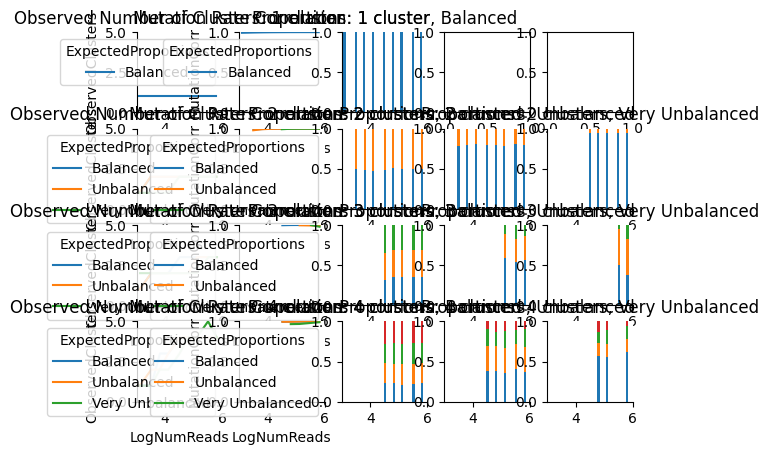

Library: 280 frag2


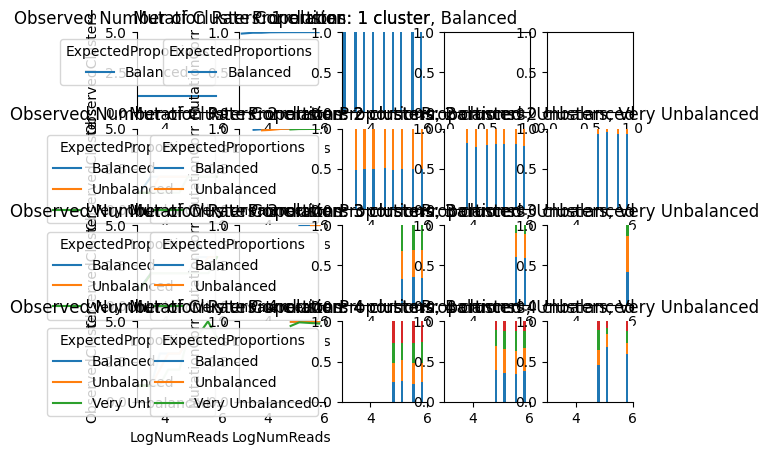

In [5]:
# Graph details of one trial.

def graph_detail(n_reads_df, proportions_df):
    for length, library in LIBRARIES:
        print("Library:", length, library)
        fig, axes = plt.subplots(MAX_CLUSTERS_REAL, len(PROP_NAMES) + 2)
        for order in list_orders():
            # Select data.
            n_reads_df_selector = np.logical_and.reduce([n_reads_df["Library"] == library,
                                                         n_reads_df["ReferenceLength"] == length,
                                                         n_reads_df["ExpectedClusters"] == order])
            n_reads_df_selected = n_reads_df.loc[n_reads_df_selector]
            proportions_order = proportions_df[order]
            # Graph number of clusters observed.
            axis = axes[order - 1, 0]
            sns.lineplot(n_reads_df_selected,
                         y="ObservedClusters",
                         x="LogNumReads",
                         hue="ExpectedProportions",
                         markers=True,
                         ax=axis)
            axis.spines.top.set_visible(False)
            axis.spines.right.set_visible(False)
            axis.set_xlim((3., 6.))
            axis.set_ylim((0, 5))
            axis.set_title(f"Observed Number of Clusters: {order} cluster{'s' if order > 1 else ''}")
            # Graph correlation of mutation rates.
            axis = axes[order - 1, 1]
            sns.lineplot(n_reads_df_selected,
                         y="MutationCorr",
                         x="LogNumReads",
                         hue="ExpectedProportions",
                         markers=True,
                         ax=axis)
            axis.spines.top.set_visible(False)
            axis.spines.right.set_visible(False)
            axis.set_xlim((3., 6.))
            axis.set_ylim((0., 1.))
            axis.set_title(f"Mutation Rate Correlation: {order} cluster{'s' if order > 1 else ''}")
            for pnum, pname in list_proportions(order):
                # Select data.
                proportions_selector = np.logical_and.reduce([proportions_order["Library"] == library,
                                                              proportions_order["ReferenceLength"] == length,
                                                              proportions_order["ExpectedProportions"] == pname])
                proportions_selected = proportions_order[proportions_selector]
                # Graph cluster proportions.
                axis = axes[order - 1, pnum + 1]
                bottom = 0.
                for cluster in range(1, order + 1):
                    cname = f"Cluster {cluster}"
                    x = proportions_selected["LogNumReads"]
                    y = proportions_selected[cname]
                    axis.bar(x, y, bottom=bottom, label=cname, width=0.08)
                    bottom += y
                axis.spines.top.set_visible(False)
                axis.spines.right.set_visible(False)
                axis.set_xlim((3., 6.))
                axis.set_ylim((0., 1.))
                axis.set_title(f"Proportions: {order} cluster{'s' if order > 1 else ''}, {pname}")
        plt.show()

graph_detail(n_reads_df_trial, proportions_df_trial)

In [6]:
n_reads_df

,ReferenceLength,Trial,ExpectedClusters,ExpectedProportions,NumReadsBin,NumReads,LogNumReads,NumUniqReads,Library,ObservedClusters,MutationRMSD,MutationCorr,ProportionRMSD
0,280,0,1,Balanced,1,1256,3.098990,982,ampl2,1,0.003279,0.991595,0.0
1,280,0,1,Balanced,2,3078,3.488269,2155,ampl2,1,0.002603,0.994870,0.0
2,280,0,1,Balanced,3,6159,3.789510,4103,ampl2,1,0.002061,0.996830,0.0
3,280,0,1,Balanced,4,12333,4.091069,7529,ampl2,1,0.001527,0.998154,0.0
4,280,0,1,Balanced,5,30755,4.487916,16388,ampl2,1,0.001113,0.999143,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,280,11,4,Very Unbalanced,5,31780,4.502154,30283,frag2,2,NaN,NaN,NaN
2156,280,11,4,Very Unbalanced,6,63455,4.802466,58882,frag2,2,NaN,NaN,NaN
2157,280,11,4,Very Unbalanced,7,127134,5.104262,114568,frag2,2,NaN,NaN,NaN
2158,280,11,4,Very Unbalanced,8,317055,5.501135,270458,frag2,2,NaN,NaN,NaN


In [80]:
# Graph a summary of all trials.

CLUST_COLORS = {1: "#0072b2",
                2: "#cc79a7",
                3: "#d55e00", 
                4: "#e69f00",
                5: "#f0e442"}

def graph_num_clusters(n_reads_df: pd.DataFrame):
    for length, library in LIBRARIES:
        print(length, library)
        fig, axes = plt.subplots(MAX_CLUSTERS_REAL, len(PROP_NAMES))
        fig.set_size_inches(90. * MM_TO_INCH, 120. * MM_TO_INCH)
        for order in list_orders():
            for pnum, pname in list_proportions(order):
                axis = axes[order - 1, pnum - 1]
                for num_reads_bin in range(1, len(NUM_READS) + 1):
                    bottom = 0.
                    # Select data.
                    n_reads_df_selector = np.logical_and.reduce([n_reads_df["Library"] == library,
                                                                 n_reads_df["ReferenceLength"] == length,
                                                                 n_reads_df["ExpectedClusters"] == order,
                                                                 n_reads_df["ExpectedProportions"] == pname,
                                                                 n_reads_df["NumReadsBin"] == num_reads_bin])
                    n_reads_df_selected = n_reads_df.loc[n_reads_df_selector]
                    for num_clusters in range(1, MAX_CLUSTERS_OBS + 1):
                        label = f"{num_clusters} cluster{'s' * (num_clusters > 1)}"
                        height = np.count_nonzero(n_reads_df_selected["ObservedClusters"] == num_clusters)
                        axis.bar(num_reads_bin, height, bottom=bottom, label=label, width=0.8, color=CLUST_COLORS[num_clusters])
                        bottom += height
                axis.spines.top.set_visible(False)
                axis.spines.right.set_visible(False)
                axis.set_xlim((0, len(NUM_READS) + 1))
                axis.set_ylim((0, NUM_TRIALS))
                if pnum == 1:
                    axis.set_yticks(np.arange(0, NUM_TRIALS + 1, 6))
                    axis.yaxis.set_tick_params(length=0.5 * MM_TO_POINT)
                else:
                    axis.spines.left.set_visible(False)
                    axis.set_yticks([])
                axis.set_aspect(ASPECT * len(NUM_READS) / NUM_TRIALS)
                axis.set_xticks(np.arange(1, len(NUM_READS) + 1))
                axis.set_xticklabels(ascii_uppercase[:len(NUM_READS)])
                axis.xaxis.set_tick_params(length=0.)
                axis.yaxis.set_tick_params(width=0.1 * MM_TO_POINT)
                axis.spines.left.set_linewidth(0.2 * MM_TO_POINT)
                axis.spines.bottom.set_linewidth(0.2 * MM_TO_POINT)
            for pnum in range(list_proportions(order)[-1][0] + 1, len(PROP_NAMES) + 1):
                axis = axes[order - 1, pnum - 1]
                axis.axis("off")
        plt.tight_layout(h_pad=-6.0, w_pad=1.0)
        plt.savefig(f"ref-{length}_{library}.png", dpi=300)
        plt.close()

graph_num_clusters(n_reads_df)

280 ampl2
280 frag2
